DSBA-6165 - Project - Stage 3.5<br>
Dataset Balancing<br><br>
Group 2:<br>
<li>Seve Jimenez<br>
<li>Bikash Khadka<br>
<li>Michael Tricanowicz

## Dataset Update

The size of the dataset makes it difficult and time consuming to work with. It takes a long time to load the images from the file paths. It also makes it difficult to set up train and test sets and build and run models due to the memory requirements to perform the operations on an image set this large.<br>

Furthermore, there is a significant class imbalance among the labels present in the dataset.<br>

Therefore, to facilitate more effective and efficient work, the full dataset will be reduced and balanced. An equal count of each class will be targeted (though exactly even distribution is not necessary). All over-represented classes will be randomly sampled to obtain the target count. The under-represented classes will have augmented images generated and added until the target count is reached. Given 10 labels plus no label for 11 total classes, a target of 200 of each label will set to reduce the 16000+ image dataset to closer to 2000 images with a more even class distrubution.<br>

Once created, the balanced dataset will be exported as a PyTorch file to simplify loading for modeling.

# Data Setup

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

In [8]:
# Set global random state variable
random_state = 20256165

In [9]:
# Set the target count for each label
target_count = 200

## Reload the Images

In [ ]:
# Set working directory/root folder variable containing all the images and label.txt file
root_folder = "***ENTER FOLDER HERE***" # change this as necessary for your folder path

In [ ]:
# Import the text file containing the class labels for all the videos
label_file = os.path.join(root_folder, "IAUFD Labels.txt")

In [12]:
# Define a function to read Labels from the .txt File
def load_labels(label_file):
    with open(label_file, "r") as f:
        lines = f.readlines()

    # Extract category names (use the first row which contains column headers, skip first column which is the image id # key)
    classes = lines[0].strip().split("\t")[1:]  

    # Create dictionary to store image labels
    labels_dict = {}

    # Read the image/label mappings (skipping the header row)
    for line in lines[1:]:
        values = line.strip().split("\t")
        image_number = int(values[0])  # Extract image number as key (first column)
        one_hot_vector = np.array([int(v) if v.strip() else 0 for v in values[1:]])  # convert label row to NumPy array
        assigned_classes = [classes[i] for i, val in enumerate(one_hot_vector) if val == 1] # get category names where value is 1
        labels_dict[image_number] = assigned_classes  # store image class and image in the dictionary by image number

    return classes, labels_dict

In [13]:
# Load labels. This provides a list of classes plus a dictionary of each image with their assigned labels.
classes, labels_dict = load_labels(label_file)

In [14]:
# Locate the file paths for all images in the dataset
image_paths = []
for root, dirs, files in os.walk(root_folder):
    for file in files:
        if file.endswith((".jpg", ".png", ".jpeg")):  # identify all files with the listed filetypes to be added to the image list
            image_paths.append(os.path.join(root, file))

In [15]:
%%time
import cv2
# Set preferred standard size for the images. This will resize the images so that all are img_dim x img_dim.
img_dim = 224

# Dictionary to store image data with labels
image_data = {}

load_count = 0
print("Loading images.")

for image_path in image_paths:
    img = cv2.imread(image_path)  # Read image from the image path located
    if img is None:
        print(f"Could not load {image_path}")
        continue
    img = cv2.resize(img, (img_dim, img_dim))  # Resize for CNN input
    img = img / 255.0  # Normalize pixel values
    
    # Extract the image number from the filename
    image_number = int(os.path.splitext(os.path.basename(image_path))[0])
    
    # Get the corresponding one-hot label from the dictionary
    label = labels_dict.get(image_number, np.zeros(len(classes)))  # Default to zero vector if missing
    
    # Store in dictionary
    image_data[image_number] = (label, img)

    print(f"Image {image_number}: Label {label}")
    load_count += 1

print(f"Loading complete. Loaded {load_count} images.")

Loading images.
Image 1: Label ['Stadium View']
Image 10: Label ['Ball', 'Referee']
Image 100: Label ['Yellow Card', 'Referee']
Image 1000: Label []
Image 10000: Label ['Ball']
Image 100000: Label ['Referee']
Image 10001: Label ['Ball']
Image 10002: Label ['Ball']
Image 10003: Label []
Image 10004: Label ['Goal ']
Image 10005: Label ['Ball']
Image 10006: Label ['Ball']
Image 10007: Label ['Goal ', 'Ball']
Image 10008: Label ['Goal ', 'Ball']
Image 10009: Label ['Goal ', 'Ball']
Image 1001: Label []
Image 10010: Label ['Goal ']
Image 10011: Label []
Image 10012: Label []
Image 10013: Label []
Image 10014: Label ['Goal ']
Image 10015: Label ['Goal ', 'Ball', 'Referee']
Image 10016: Label ['Goal ']
Image 10017: Label ['Ball', 'Referee']
Image 10018: Label ['Ball']
Image 10019: Label ['Ball', 'Referee']
Image 1002: Label []
Image 10020: Label ['Goal ', 'Referee']
Image 10021: Label []
Image 10022: Label []
Image 10023: Label []
Image 10024: Label []
Image 10025: Label []
Image 10026: Label

## Subset the Dataset
<li> Reduce the total number of images for smoother running on limited hardware while balancing class counts.
<li> Randomly sample over-represented label classes to decrease counts.
<li> Augment/transform images of under-represented label classes in increase counts.

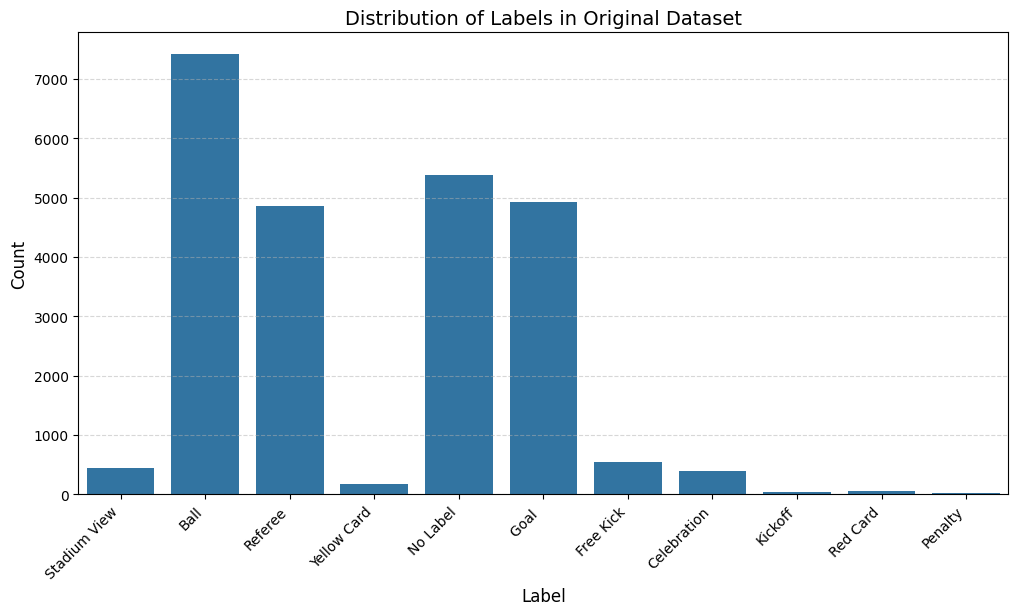

In [16]:
# Count and Visualize Image Label Distribution in the Original Dataset

# Count images per label
from collections import defaultdict
label_counts = defaultdict(list)
for img_num, (labels, img) in image_data.items():
    if not labels:  # If labels list is empty, assign "No Label"
        label_counts["No Label"].append(img_num)
    else:
        for label in labels:
            label_counts[label].append(img_num)

# Extract label counts
count_per_label=[]
for value in label_counts.values():
    count_per_label.append(len(value))

# Plot histogram of label counts
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.barplot(x=list(label_counts.keys()), y=count_per_label)
plt.xlabel("Label", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of Labels in Original Dataset", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

Define Functions to Reduce and Balance the Dataset

In [ ]:
import torch
import torchvision.transforms as T
from PIL import Image
import random

# Define augmentation transformations for adding synthetic data
augment_transform = T.Compose([
    T.RandomHorizontalFlip(p=0.5),  # randomly flip image horizontally
    T.RandomRotation(15),   # randomly rotate up to +/- 15 degrees
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),   # randomly change the brightness, contrast, saturation and hue of an image 
    T.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    T.ToTensor()  # Convert image to PyTorch tensor
])

# Define a basic tensor conversion for non-augmented images
to_tensor = T.ToTensor()    # Convert image to PyTorch tensor

# Function to apply augmentations
def augment_image(img):
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)  # Normalize if needed
    img = Image.fromarray(img)  # Convert NumPy array to PIL
    img = augment_transform(img)  # Apply augmentation
    return img  # Returns a transformed PyTorch tensor

# Function to balance dataset with equal number of examples of each label through undersampling and augmentation
def balance_dataset(image_data, label_counts, target_count):
    balanced_data = {}

    for label, img_nums in label_counts.items():
        images = [(img_num, image_data[img_num]) for img_num in img_nums]

        # Undersample overrepresented classes (keep original images)
        if len(images) > target_count:
            selected_images = random.sample(images, target_count)
            for img_num, (labels, img) in selected_images:
                balanced_data[img_num] = (labels, to_tensor(img))  # Convert image to PyTorch tensor
        else:
            # Retain all original images and apply augmentation if needed
            for img_num, (labels, img) in images:
                balanced_data[img_num] = (labels, to_tensor(img))  # Convert image to PyTorch tensor

            # Oversample using augmentation
            extra_needed = target_count - len(images)
            for _ in range(extra_needed):
                img_num, (labels, img) = random.choice(images)  # Select a random image
                img_aug = augment_image(img)  # Apply augmentation
                new_img_num = f"{img_num}_aug{_}"  # Unique key
                balanced_data[new_img_num] = (labels, img_aug)  # Store augmented image

    return balanced_data


In [18]:
%%time
# Oversample underrepresented classes with augmentations
balanced_dataset = balance_dataset(image_data, label_counts, target_count)

CPU times: total: 17.7 s
Wall time: 9.03 s


In [19]:
# Print dataset size
print(f"Final dataset size: {len(balanced_dataset)}")

Final dataset size: 2147


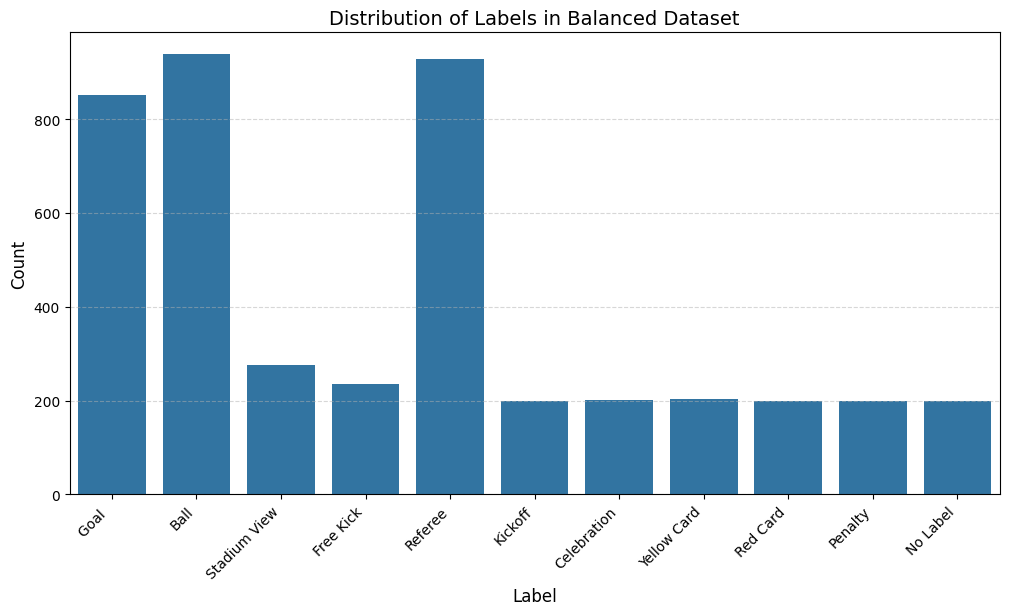

In [21]:
# Count and Visualize Image Label Distribution in the Balanced Data Set

# Count images per label
balanced_label_counts = defaultdict(list)
for img_num, (labels, img) in balanced_dataset.items():
    if not labels:  # If labels list is empty, assign "No Label"
        balanced_label_counts["No Label"].append(img_num)
    else:
        for label in labels:
            balanced_label_counts[label].append(img_num)

# Extract label counts
balanced_count_per_label=[]
for value in balanced_label_counts.values():
    balanced_count_per_label.append(len(value))

# Plot histogram of label counts
plt.figure(figsize=(12, 6))
sns.barplot(x=list(balanced_label_counts.keys()), y=balanced_count_per_label)
plt.xlabel("Label", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of Labels in Balanced Dataset", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

The dataset has been successfully reduced with a better balance achieved. There still exists an overrepresentation of three labels (goal, ball, and referee) likely due to their overall prevelance and presence in images with multiple labels. However the difference between these labels and the others has been reduced such that a more robust model can be trained using the data.

# Output the Balanced Data Set

The dataset PyTorch file can be downloaded [here](https://drive.google.com/file/d/1HgRtiw9ob1c_GqSUv5S9PwMX84GhTbUg/view?usp=sharing). It is approximately 2.2GB and contains the 2147 image subset with corresponding labels.

In [22]:
# Save the dataset as a PyTorch file
torch.save(balanced_dataset, "balanced_dataset.pt")
print("Dataset saved successfully!")

Dataset saved successfully!
